#### imports

In [1]:
import torch
import os
import csv

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image
from transformers import AutoModel, AutoTokenizer
from torchvision import transforms
from tqdm import tqdm
from IPython.display import display

#### model

In [2]:
cuda_available = torch.cuda.is_available()
print("CUDA available:", cuda_available)

CUDA available: True


In [3]:
model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2', trust_remote_code=True, torch_dtype=torch.bfloat16)
model = model.to(device='cuda', dtype=torch.bfloat16)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2', trust_remote_code=True)
model.eval()

MiniCPMV(
  (llm): MiniCPMForCausalLM(
    (model): MiniCPMModel(
      (embed_tokens): Embedding(122753, 2304)
      (layers): ModuleList(
        (0-39): 40 x MiniCPMDecoderLayer(
          (self_attn): MiniCPMSdpaAttention(
            (q_proj): Linear(in_features=2304, out_features=2304, bias=False)
            (k_proj): Linear(in_features=2304, out_features=2304, bias=False)
            (v_proj): Linear(in_features=2304, out_features=2304, bias=False)
            (o_proj): Linear(in_features=2304, out_features=2304, bias=False)
            (rotary_emb): MiniCPMRotaryEmbedding()
          )
          (mlp): MiniCPMMLP(
            (gate_proj): Linear(in_features=2304, out_features=5760, bias=False)
            (up_proj): Linear(in_features=2304, out_features=5760, bias=False)
            (down_proj): Linear(in_features=5760, out_features=2304, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): MiniCPMRMSNorm()
          (post_attention_layernorm): Min

In [5]:
def save_to_csv(context, question, image_str, output, filename='output.csv'):
    with open(filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([context, question, image_str, output])

In [6]:
def test(file_path, img_path, qcontext, question, count):
    tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2', trust_remote_code=True)
    model.eval()
    msgs = [{'role': 'user', 'content': question}]

    full_image = os.path.join(file_path, img_path)
    # _, _, img = Image.open(full_image).convert('RGB').split()
    img = Image.open(full_image).convert('RGB')
    
    res, context, _ = model.chat(
        image=img,
        msgs=msgs,
        context=qcontext,
        tokenizer=tokenizer,
        sampling=True,
        temperature=0.7
    )
    if count:
        filename='counts.csv'
        save_to_csv(qcontext, question, img_path, res, filename)
    else:
        save_to_csv(qcontext, question, img_path, res)
        
    return res, img

In [7]:
!pip install torchviz

Defaulting to user installation because normal site-packages is not writeable


#### workspace

In [8]:
path = '../full_images'
files = os.listdir(path)
full_images = [file for file in files if file.endswith('.tif')]
full_images.sort()
len(full_images)

189

In [9]:
questions = ['There are many nuclei','You are a pathologist examing cell imagery', 'You are a scientist', None, 'The nuclei are blue stained imagery', 'Be as accurate as possible', 'Make sure to reason through your answer', 'Double check your work', 'Make sure to analyze the image thorougly']
for i in tqdm(range(len(questions)), desc='Processing images'):
    context = questions[i]
    question = 'Give the count of nuclei in the image. You must return a numerical answer.'
    res, img = test(path, full_images[0], context, question, False)

Processing images: 100%|██████████| 9/9 [00:37<00:00,  4.15s/it]


In [10]:
# for i in tqdm(range(len(full_images)), desc='Processing images'):
#     context = 'You are a pathologist examing cell imagery.'
#     question = 'Give a detailed analysis of the image. Be as scientifically accurate as possible.'
#     res, img = test(path, full_images[i], context, question, False)

In [11]:
# df = pd.read_csv('output.csv')
# df.head()

In [12]:
# img_str =  "BT474 Color Combine_HER2 FISH.tif"
# filtered_df = df[df['Image String'] == img_str]
# img = Image.open(os.path.join(path, img_str))
# plt.imshow(img)
# display(filtered_df)

In [13]:
# unique_outputs = filtered_df['Output'].unique()

In [14]:
# list(unique_outputs)

10
12


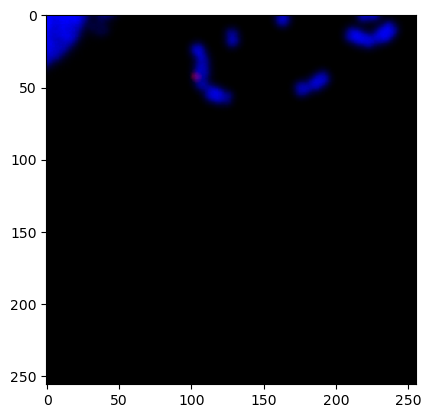

In [28]:
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2', trust_remote_code=True)
model.eval()
qcontext = 'You are a pathologist examing cell imagery'
question = 'Count the number of nuclei, you can only return a single number as your answer'
msgs = [{'role': 'user', 'content': question}]
# _, _, img = Image.open(full_image).convert('RGB').split()
img = Image.open('../sampled/10.png').convert('RGB')

res, context, _ = model.chat(
    image=img,
    msgs=msgs,
    context=qcontext,
    tokenizer=tokenizer,
    sampling=True,
    temperature=0.7
)


print(res)
plt.imshow(img)

msgs.append({"role": "assistant", "content": res})
msgs.append({"role": "user", "content": "Increase your previous answer by 2"})

res, context, _ = model.chat(
    image=img,
    msgs=msgs,
    context=qcontext,
    tokenizer=tokenizer,
    sampling=True,
    temperature=0.7
)

print(res)
plt.imshow(img)

In [16]:
# torch.manual_seed(100)

# tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2', trust_remote_code=True)

# image = Image.open('../sampled/11.png').convert('RGB')

# # First round chat 
# question = "What is the landform in the picture?"
# msgs = [{'role': 'user', 'content': [image, question]}]

# answer = model.chat(
#     msgs=msgs,
#     tokenizer=tokenizer
# )
# print(answer)

# # Second round chat, pass history context of multi-turn conversation
# msgs.append({"role": "assistant", "content": [answer]})
# msgs.append({"role": "user", "content": ["What should I pay attention to when traveling here?"]})

# answer = model.chat(
#     msgs=msgs,
#     tokenizer=tokenizer
# )
# print(answer)

### todo
* n-shot learning with 0, 1, and say 10
* graph results of different learning types
* understand minicpm llm aspect
* different context analysis
* descriptions of ecdna